In [ ]:
# this program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) to predict the closing stock price of a corp, 
# using the past 60 days' stock price


In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 14.4 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 11.4 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [ ]:
# import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
import requests

session = requests.session()
session.headers['User-Agent'] = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'

df = web.DataReader('MSFT', data_source='yahoo', start='2012-01-01', end='2022-12-13', session=session)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,26.959999,26.389999,26.549999,26.770000,64731500.0,21.466700
2012-01-04,27.469999,26.780001,26.820000,27.400000,80516100.0,21.971893
2012-01-05,27.730000,27.290001,27.379999,27.680000,56081400.0,22.196423
2012-01-06,28.190001,27.530001,27.530001,28.110001,99455500.0,22.541239
2012-01-09,28.100000,27.719999,28.049999,27.740000,59706800.0,22.244535
...,...,...,...,...,...,...
2022-12-07,246.160004,242.210007,244.830002,244.369995,20481500.0,244.369995
2022-12-08,248.740005,243.059998,244.839996,247.399994,22611800.0,247.399994
2022-12-09,248.309998,244.160004,244.699997,245.419998,20607100.0,245.419998


In [ ]:
# get the number of rows and columns in the dataset
df.shape

(2756, 6)

<function matplotlib.pyplot.show(*args, **kw)>

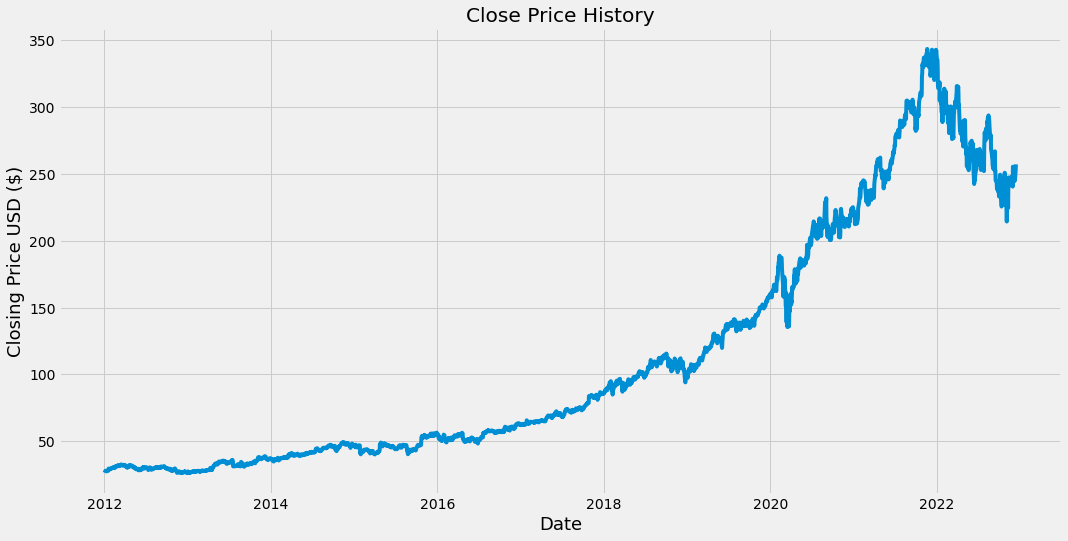

In [ ]:
# visualise the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)
plt.show

In [ ]:
# Create a new dataframe with only the Close column
data = df.filter(['Close'])
# convert the dataframe to a numpy array
dataset = data.values
# get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

2205

In [ ]:
# scale the data
# computes the minimum and maximum value to be scaled and transforms the data based on these 2 values
# rationale: https://analyticsindiamag.com/why-data-scaling-is-important-in-machine-learning-how-to-effectively-do-it/#:~:text=So%20if%20the%20data%20in,between%20them%20will%20be%20lower.

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00126286],
       [0.00325187],
       [0.00413588],
       ...,
       [0.69157671],
       [0.71396099],
       [0.72788414]])

In [ ]:
# create training dataset
# create Scaled training dataset
train_data = scaled_data[0:training_data_len , :]

#split data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i<=61:
    print(x_train) # contains the past 60 values as base values
    print(y_train) # contains the values we want to predict
    print()

[array([0.00126286, 0.00325187, 0.00413588, 0.00549346, 0.00432531,
       0.00464103, 0.00426217, 0.00514617, 0.00593547, 0.00596704,
       0.00587232, 0.00552504, 0.01054492, 0.01060807, 0.00937677,
       0.01007135, 0.00988192, 0.00902948, 0.01022921, 0.00997664,
       0.01111321, 0.01130265, 0.01221822, 0.01209194, 0.01256551,
       0.01354423, 0.01389152, 0.01303908, 0.01329166, 0.01224979,
       0.01161836, 0.01553325, 0.01540696, 0.01600682, 0.0154701 ,
       0.01578582, 0.0161331 , 0.01572267, 0.0173644 , 0.01695397,
       0.01869041, 0.01802741, 0.01714339, 0.01638568, 0.01726968,
       0.0178064 , 0.01774326, 0.01790112, 0.01989012, 0.02020585,
       0.02045841, 0.01966912, 0.01840626, 0.01774326, 0.01749068,
       0.01777483, 0.0178064 , 0.01963756, 0.01941656, 0.01837469])]
[0.018153685590104426]

[array([0.00126286, 0.00325187, 0.00413588, 0.00549346, 0.00432531,
       0.00464103, 0.00426217, 0.00514617, 0.00593547, 0.00596704,
       0.00587232, 0.00552504, 0.0

In [ ]:
# convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
# reshape the data
# we need to do this since LSTM is 3D and our x_train and y_train data is 2D
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # the first two numbers represent row and column, and the last number is just the closing price
x_train.shape

(2145, 60, 1)

In [ ]:
# build the LTSM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))


In [ ]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2145/2145 [==============================] - 59s 26ms/step - loss: 5.8241e-04


In [ ]:
# create testing data set
# create a new array containing scaled values from inded 1543 to 2003
test_data = scaled_data[training_data_len - 60: , :]
# create the datasets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :] # this will be the value that we want our model to predict
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0]) # this contains the past 60 values


In [ ]:
# convert data to a numpy array
x_test = np.array(x_test)

In [ ]:
# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # unscale the values. we want predictions to contain the same values as our y_test dataset

18/18 [==============================] - 1s 17ms/step


In [ ]:
# get the root mean squared error (RMSE) to evaluate the model
rmse = np.sqrt( np.mean(predictions - y_test)**2)
rmse # 0 is the perfect value, it means the model got the predictions right

10.517445752927916

<ipython-input-19-f7fd5de0e761>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


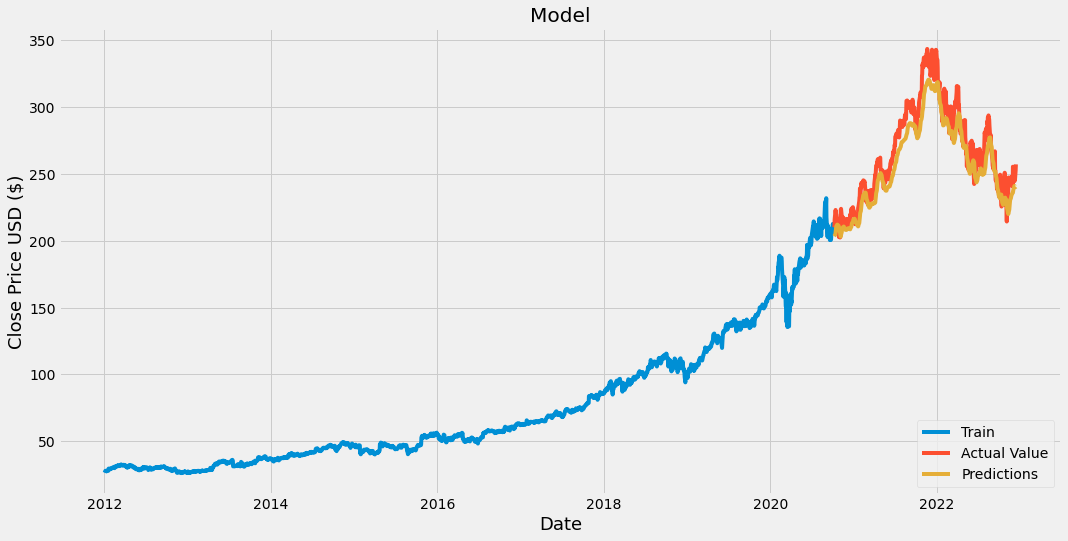

In [ ]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# visualise the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual Value', 'Predictions'], loc='lower right')
plt.show()



In [ ]:
# show the valid and predicted prices
valid

,Close,Predictions
Date,,
2020-10-07,209.830002,203.261292
2020-10-08,210.580002,203.482895
2020-10-09,215.809998,203.785980
2020-10-12,221.399994,204.527252
2020-10-13,222.860001,205.888931
...,...,...
2022-12-07,244.369995,240.794907
2022-12-08,247.399994,240.593613
2022-12-09,245.419998,240.382034


In [ ]:
# get the quote
import requests

session = requests.session()
session.headers['User-Agent'] = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'

microsoft_quote = web.DataReader('MSFT', data_source='yahoo', start='2012-01-01', end='2022-12-13', session=session)

# create a new dataframe
new_df = microsoft_quote.filter(['Close'])
# get the last 60 days losing price values and covert the dataframe to an array
last_60_days = new_df[-60:].values
# scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# create an empty list
X_test = []
# append the past 60 days to to x_test
X_test.append(last_60_days_scaled)
# convert the X_test dataset to a numpy array
X_test = np.array(X_test)
# reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# get the predicted scaled price
pred_price = model.predict(X_test)
# undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price) # actual price: $256.92

1/1 [==============================] - 0s 85ms/step
[[240.92653]]


In [ ]:
# compare with actual price
import requests

session = requests.session()
session.headers['User-Agent'] = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'

microsoft_quote2 = web.DataReader('MSFT', data_source='yahoo', start='2022-12-13', end='2022-12-13', session=session)
print(microsoft_quote2['Close'])


Date
2022-12-13    256.920013
Name: Close, dtype: float64
